# Final Project
DS 2500 - Data Wrangling
Richard Timpson

For the final project I would like to further explore forecasting for both home energy consumption and photovaltaic solar energy production. I have previously built two different models for each problem that used different methods for forecasting. For PV production I used a standard ordinary least squares regression using weather and solar irradiance to predict energy production. For the home energy consumption I used a basic autoregressive model to forecast further home consumption. 

In this notebook and project, I am going to combine both of these methods into one to create two separate models that use a combination of time-series forecasting methods with other standard regression methods using other data as explantory variables. Because the PV production data is time-series data, I would like to simply add that type of analysis into the existing model. For the home consumption data I want to add other explantory variables. Right now my plan is to add weather variables to see how it affects the model, but there is other data that I am going to collect if I can such as the size of the house and information about the appliances. 

# PV Energy Forecasting
To start out, I am going to build on work that I have done in another class that relates to a linear regressive model for PV forecasting. This model uses weather and solar irradiance as explantory variables, but does not consider the auto correlations in the data. This will require some feature engineering to add the lags into the existing data. It should be as simple as adding the lags with the other variables and seeing how this affects the regressive model. 

In [151]:
import train_test_split
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
DATA_DIR = '../../../data'

Read in relevant PV site metadata

In [152]:
import json

with open(f'{DATA_DIR}/production_data/site_metadata_anon.json', 'r') as file:
    s = file.read()
    site_md = json.loads(s)

## Data and Feature Engineering
Read in all of the data sets. This code was used from another project so it is getting the data as numpy vectors rather than pandas data frames. I will be putting it in a dataframe later. I am getting a train test split on the data set by sampling from the data over a 4 day window and choosing 75% of the values from these 4 days for the train, adn 25% of the values for the test set. This gurantees that all seasons will be represented in the data equally and that the model evaluation should be more reliable. 

### Feature Engineering methods

In [207]:
from sklearn.model_selection import TimeSeriesSplit
import datetime 
from calendar import isleap

def set_irr_df_dt(df, tz):
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df = df.set_index('date')
    df = df.resample('1H').mean()
    df.index = df.index.tz_localize(tz, nonexistent='NaT', ambiguous='NaT')
    df = df[['GHI','DHI','DNI']]
    return df 

def set_prod_df_dt(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df 

def read_weather_irr_df(site):
    site_id = site['id']
    timezone = site['location']['timeZone']
    irradiance_id = site['irradiance_site_id']
    production_path = f'{DATA_DIR}/production_data/{site_id}/combination_data/production_weather_combination.csv'
    irradiance_path = f'{DATA_DIR}/irradiance_data/{irradiance_id}/irradiance_data.csv'

    prod_df = pd.read_csv(production_path)
    prod_df = set_prod_df_dt(prod_df)
    irr_df = pd.read_csv(irradiance_path)
    irr_df = set_irr_df_dt(irr_df, timezone)

    return prod_df, irr_df

def combine_weather_df(irr_df, prod_df):
    df = irr_df.merge(prod_df, how='inner', left_index=True, right_index=True)

    # It's important to note that the resulting datetime index will be in UTC after the merge 
    return df


def clean_df(df):
    df = df.dropna(subset=['production'])
    df = df[df['production'] != 0]
    df = df.drop(columns=['precipType'])
    return df 

def add_lags(df, num_lags):
    for i in range(num_lags):
        df[f'production_lag_{i+1}'] = df['production'].shift(i+1)
        # we need to replace the missing values for all of the lags. For now I'm going to replace the missing values with the mean of column this probably is not the optimal solution but it should be good enough for this experiment 
        
        mean = df[f'production_lag_{i+1}'].mean()
        df[f'production_lag_{i+1}'].fillna(mean, inplace=True)

    return df 

def get_final_df(site, num_lags): 
    prod_df, irr_df = read_weather_irr_df(site)
    df = combine_weather_df(irr_df, prod_df)
    df = clean_df(df)
    df = add_lags(df, num_lags)
    df = add_seasonality(df)
    return df 

def day_trans(row):
    year = row.name.year 
    # dt = datetime.datetime.fromtimestamp(row.name)
    # day_of_year = dt.timetuple().tm_yday
    day_of_year = row.name.dayofyear
    days_in_year = 366 if isleap(year) else 365
    return np.sin(day_of_year * np.pi / days_in_year)

# def month_trans(row):


def add_seasonality(df):
    # day = 1 + np.sin(day_of_year*np.pi / days_in_year)
    # hour = 1 + np.sin(date.hour*np.pi / 24)
    df['day'] = df.apply(day_trans, axis=1)
    df['month'] = df.apply(lambda row: row.name.month * np.pi / 12, axis=1)
    df['hour'] = df.apply(lambda row: row.name.hour * np.pi / 24, axis=1)
    return df

In [173]:
num_lags = 10

site = site_md[0]
df = get_final_df(site, num_lags)
print(df.columns)
df 

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DHI',
       'DNI', 'Wind Speed', 'Temperature', 'Solar Zenith Angle',
       'precipIntensity', 'precipProbability', 'precipAccumulation',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'pressure', 'windSpeed', 'windBearing', 'windGust', 'cloudCover',
       'uvIndex', 'visibility', 'ozone', 'production', 'production_lag_1',
       'production_lag_2', 'production_lag_3', 'production_lag_4',
       'production_lag_5', 'production_lag_6', 'production_lag_7',
       'production_lag_8', 'production_lag_9', 'production_lag_10', 'day',
       'month', 'hour'],
      dtype='object')


Unnamed: 0    Year  Month   Day  Hour  Minute  \
date                                                                       
2015-02-09 21:00:00+00:00      1900.5  2015.0    2.0   9.0  14.0    15.0   
2015-02-09 22:00:00+00:00      1902.5  2015.0    2.0   9.0  15.0    15.0   
2015-02-09 23:00:00+00:00      1904.5  2015.0    2.0   9.0  16.0    15.0   
2015-02-10 00:00:00+00:00      1906.5  2015.0    2.0   9.0  17.0    15.0   
2015-02-10 01:00:00+00:00      1908.5  2015.0    2.0   9.0  18.0    15.0   
...                               ...     ...    ...   ...   ...     ...   
2018-12-31 20:00:00+00:00     17498.5  2018.0   12.0  31.0  13.0    15.0   
2018-12-31 21:00:00+00:00     17500.5  2018.0   12.0  31.0  14.0    15.0   
2018-12-31 22:00:00+00:00     17502.5  2018.0   12.0  31.0  15.0    15.0   
2018-12-31 23:00:00+00:00     17504.5  2018.0   12.0  31.0  16.0    15.0   
2019-01-01 00:00:00+00:00     17506.5  2018.0   12.0  31.0  17.0    15.0   

                             GHI    DHI    DNI  Wind Speed  ...  \
date                                                        ...   
2015-02-09 21:00:00+00:00    0.0    0.0    0.0        1.45  ...   
2015-02-09 22:00:00+00:00  118.5   30.5  598.5        1.90  ...   
2015-02-09 23:00:00+00:00  313.5   48.0  838.5        3.10  ...   
2015-02-10 00:00:00+00:00  486.5   56.5  937.5        4.80  ...   
2015-02-10 01:00:00+00:00  613.0   61.5  984.5        5.50  ...   
...                          ...    ...    ...         ...  ...   
2018-12-31 20:00:00+00:00    0.0    0.0    0.0        1.25  ...   
2018-12-31 21:00:00+00:00    0.0    0.0    0.0        1.60  ...   
2018-12-31 22:00:00+00:00   63.5   25.0  385.0        2.85  ...   
2018-12-31 23:00:00+00:00  201.5   59.5  615.5        4.20  ...   
2019-01-01 00:00:00+00:00  263.5  107.0  413.5        4.85  ...   

                           production_lag_4  production_lag_5  \
date                                                            
2015-02-09 21:00:00+00:00          969.6563        969.622409   
2015-02-09 22:00:00+00:00          969.6563        969.622409   
2015-02-09 23:00:00+00:00          969.6563        969.622409   
2015-02-10 00:00:00+00:00          969.6563        969.622409   
2015-02-10 01:00:00+00:00         1813.9670        969.622409   
...                                     ...               ...   
2018-12-31 20:00:00+00:00          236.0000         35.000000   
2018-12-31 21:00:00+00:00          443.0000        236.000000   
2018-12-31 22:00:00+00:00          334.0000        443.000000   
2018-12-31 23:00:00+00:00          910.0000        334.000000   
2019-01-01 00:00:00+00:00         1549.0000        910.000000   

                           production_lag_6  production_lag_7  \
date                                                            
2015-02-09 21:00:00+00:00        969.625897        969.663085   
2015-02-09 22:00:00+00:00        969.625897        969.663085   
2015-02-09 23:00:00+00:00        969.625897        969.663085   
2015-02-10 00:00:00+00:00        969.625897        969.663085   
2015-02-10 01:00:00+00:00        969.625897        969.663085   
...                                     ...               ...   
2018-12-31 20:00:00+00:00        531.000000        988.000000   
2018-12-31 21:00:00+00:00         35.000000        531.000000   
2018-12-31 22:00:00+00:00        236.000000         35.000000   
2018-12-31 23:00:00+00:00        443.000000        236.000000   
2019-01-01 00:00:00+00:00        334.000000        443.000000   

                           production_lag_8  production_lag_9  \
date                                                            
2015-02-09 21:00:00+00:00        969.693901        969.736832   
2015-02-09 22:00:00+00:00        969.693901        969.736832   
2015-02-09 23:00:00+00:00        969.693901        969.736832   
2015-02-10 00:00:00+00:00        969.693901        969.736832   
2015-02-10 01:00:00+00:00        969.693901        969.736832   
...                

In [174]:
row = df.iloc[0]
print(row.name)
print(type(row.name))

2015-02-09 21:00:00+00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [156]:
dfs = {}
for site in site_md:
    try:
        df = get_final_df(site, num_lags)
    except FileNotFoundError:
        print(f'Skipping site {site["id"]}. No irradiance data ')
    dfs[site['id']] = df

Skipping site 1232644. No irradiance data 


### Plot Methods

In [211]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sb 

def plot_ac(df, lags, site_id):
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(19,5))
    ax = pd.plotting.autocorrelation_plot(df['production'], axes[0])
    ax.set_xlim((0, lags))
    sm.graphics.tsa.plot_pacf(df['production'], zero=False, lags=lags, ax=axes[1], alpha=0.5)
    axes[0].set_title(f'Autocorrelation for system {site_id}')
    axes[1].set_title(f'Partial autocorrelation for system {site_id}')

def plot_prod_corr(df, site_id, num_lags, figsize=(13,7)):
    cols = ['GHI', 'DHI', 'DNI', 'day', 'month', 'hour', 'precipIntensity', 'precipProbability', 'precipAccumulation', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windBearing', 'windGust', 'cloudCover', 'uvIndex', 'visibility', 'ozone', 'production']
    lag_cols = [f'production_lag_{i + 1}' for i in range(num_lags)]
    cols = cols + lag_cols
    height=8

    df_corr = df[cols].corr()
    df_corr = df_corr['production']
    df_corr = df_corr.sort_values()
    ax = df_corr.plot.bar(figsize=figsize)
    ax.set_title(f'Correlations to production for system {site_id}')
    plt.show()

def plot_heat(df, site_id, cols, height):
    df_corr = df[cols].corr()

    # Using masking code from: https://seaborn.pydata.org/generated/seaborn.heatmap.html
    df_mask = np.zeros_like(df_corr)
    df_mask[np.triu_indices_from(df_mask)] = True

    # Set up the plotting environment
    f,ax = plt.subplots(1,1,figsize=(17,height))

    # Make a heatmap
    sb.heatmap(df_corr,vmin=-1,vmax=1,mask=df_mask,annot=True,square=True,ax=ax,cmap='coolwarm_r')


def plot_ac_heat(df, lags, site_id, height=10):
    cols = ['production'] + [f'production_lag_{i + 1}' for i in range(lags)]
    plot_heat(df, site_id, cols,height)

def plot_weather_heat(df, lags, site_id, height=10):
    cols = [
        'precipIntensity', 
        'precipProbability', 
        'precipAccumulation', 
        'temperature', 
        'apparentTemperature', 
        'dewPoint', 
        'humidity', 
        'pressure', 
        'windSpeed', 
        'windBearing', 
        'windGust', 
        'cloudCover', 
        'uvIndex', 
        'visibility', 
        'ozone', 
        'production'
    ]
    plot_heat(df, site_id, cols, height)

def plot_irr_heat(df, lags, site_id, height=6):
    cols = [
        'GHI', 
        'DHI', 
        'DNI', 
        'production'
    ]
    plot_heat(df, site_id, cols, height)

def plot_seasonality_heat(df, lags, site_id, height=6):
    cols = [
        'day', 
        'month', 
        'hour', 
        'production'
    ]
    plot_heat(df, site_id, cols, height)

## Plots

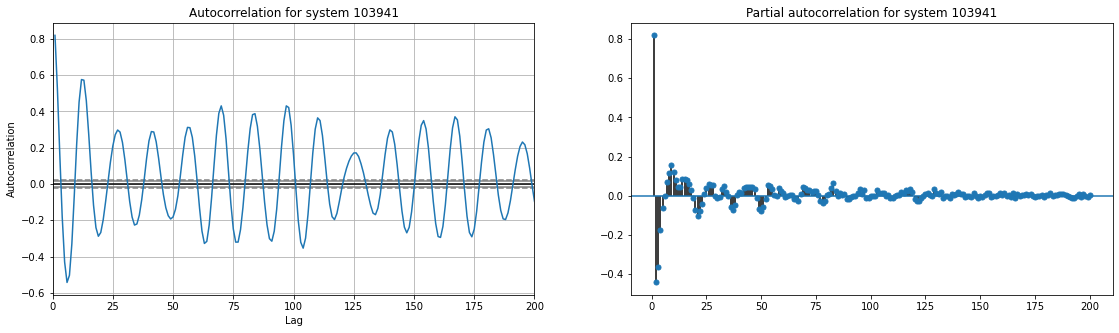

In [339]:
plot_ac(dfs[103941], 200, 103941)

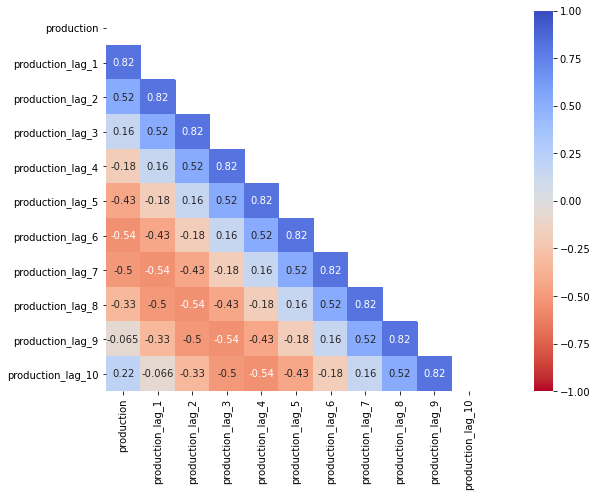

In [341]:
plot_ac_heat(dfs[103941], 10, 103941, height=7)

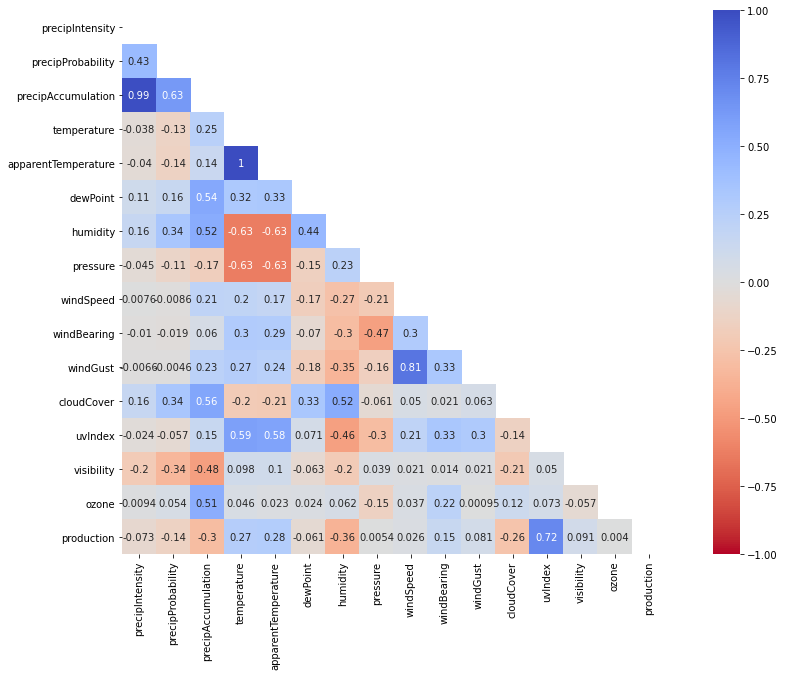

In [342]:
plot_weather_heat(dfs[103941], num_lags, 103941, height=10)

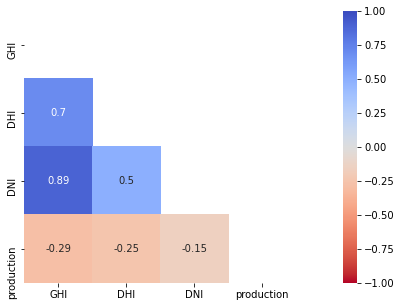

In [343]:
plot_irr_heat(dfs[103941], num_lags, 103941, height=5)

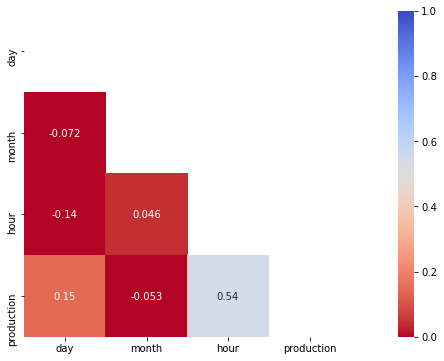

In [162]:
plot_seasonality_heat(dfs[103941], num_lags, 103941)

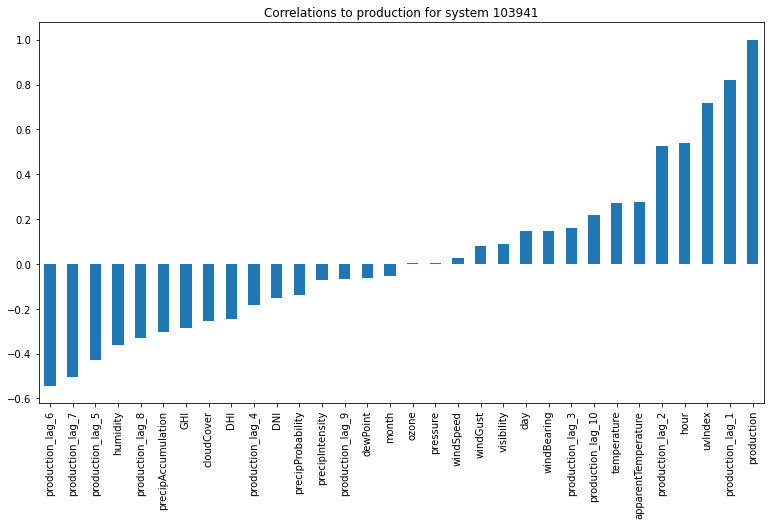

In [163]:
plot_prod_corr(dfs[103941], 103941, num_lags)

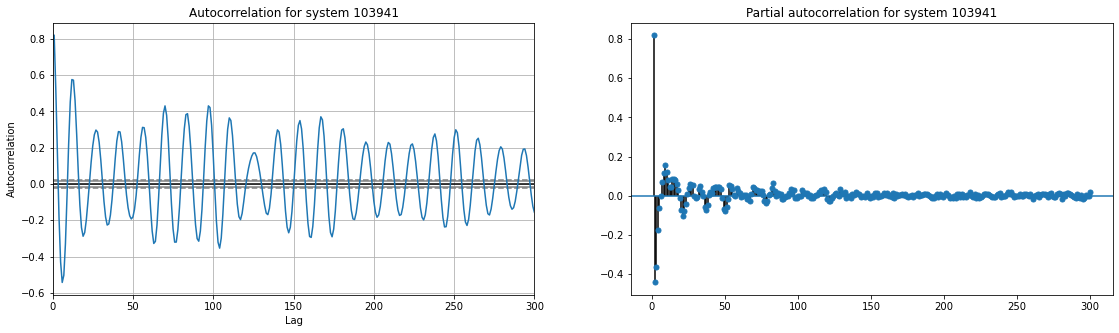

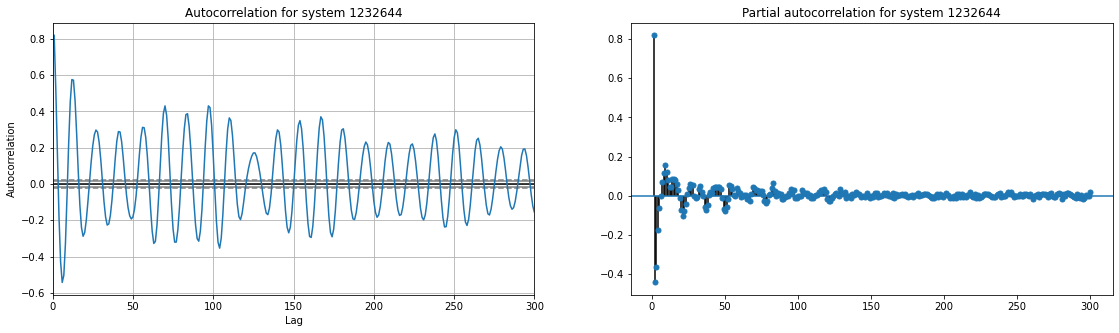

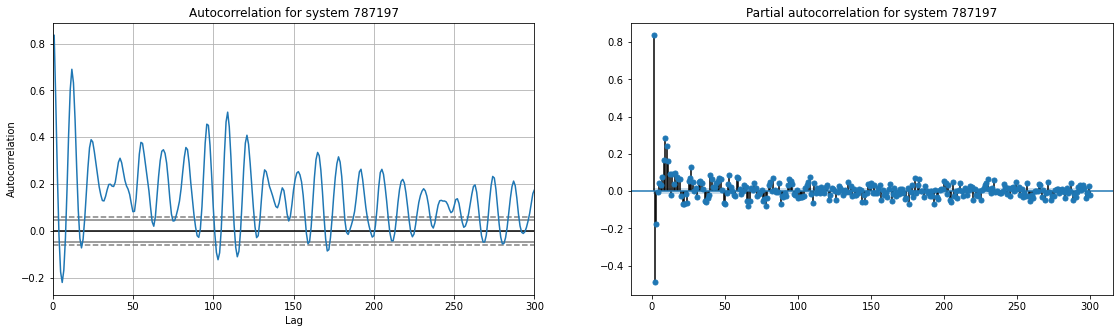

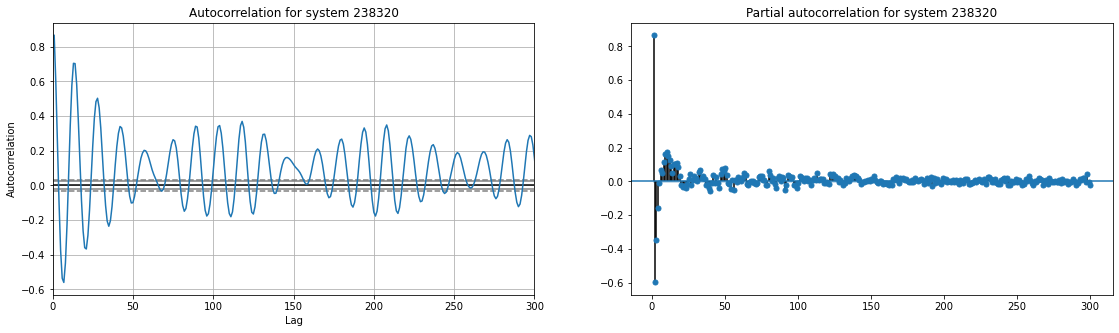

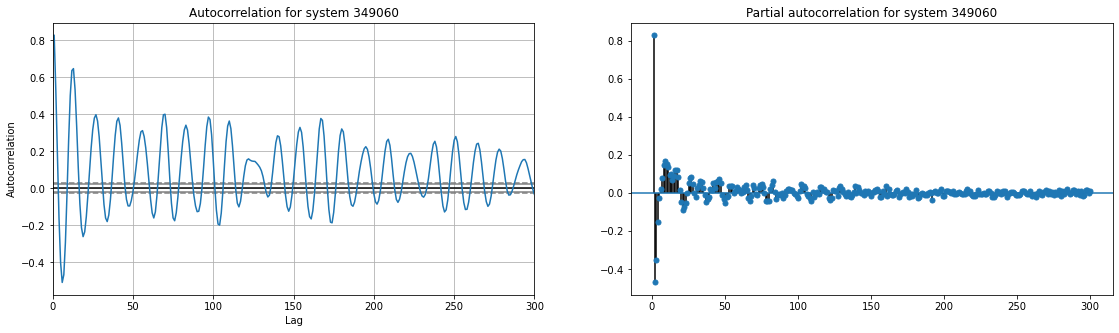

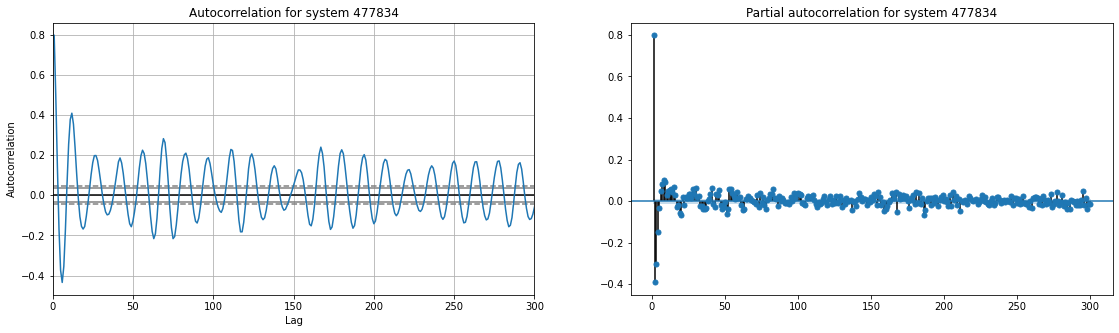

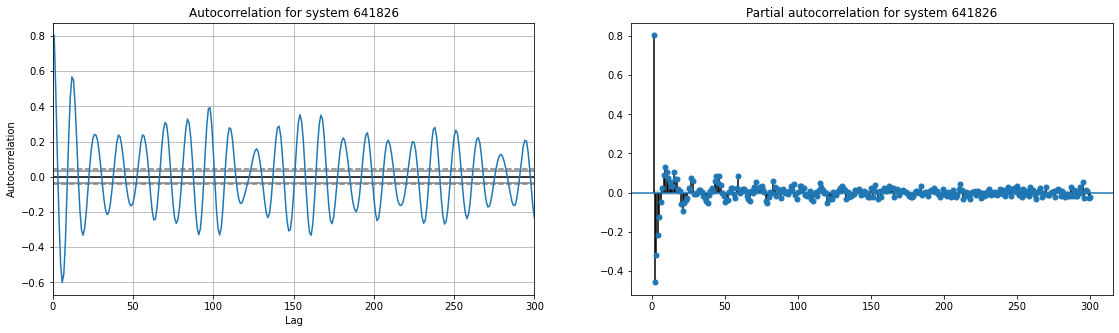

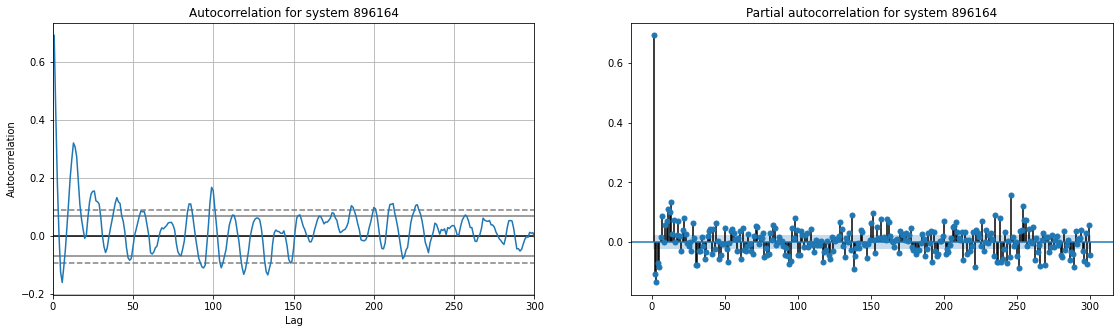

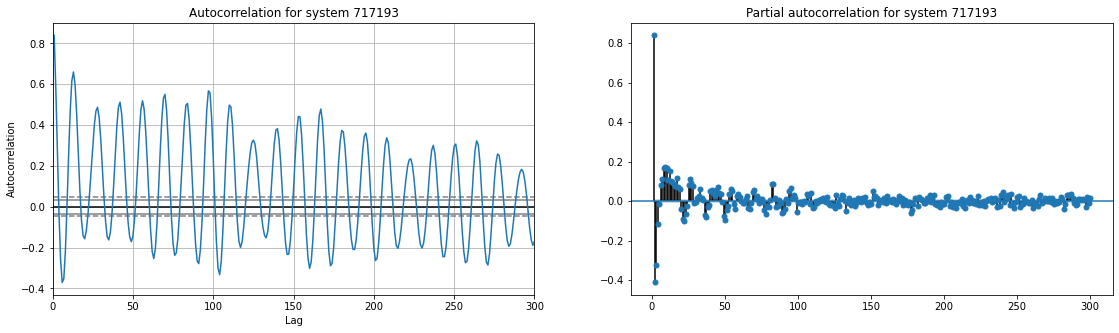

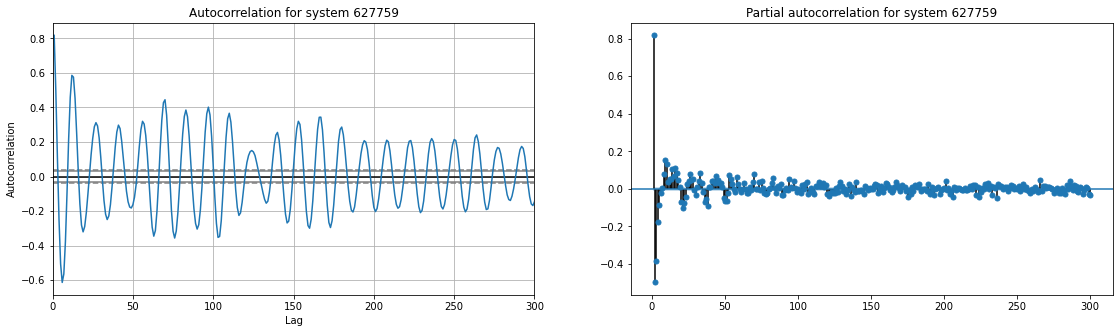

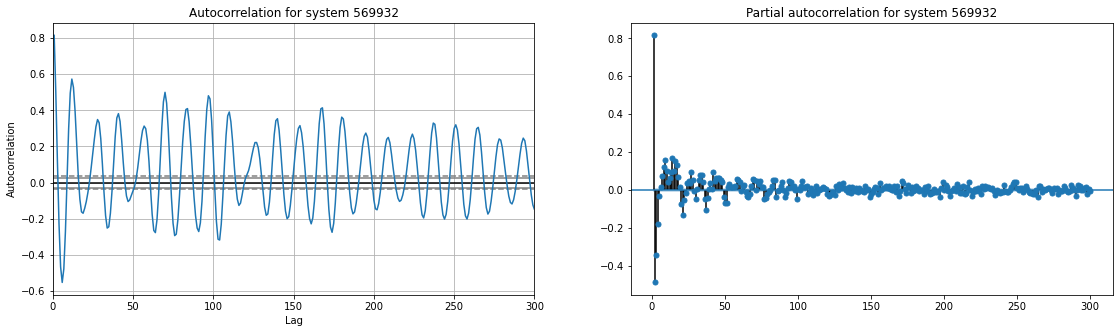

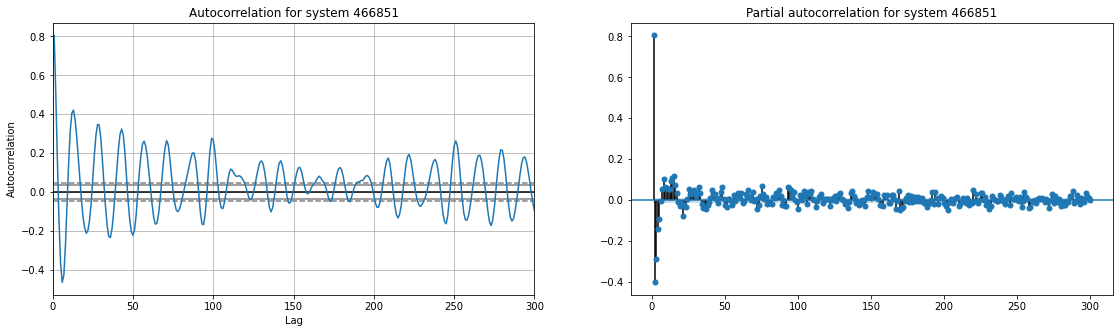

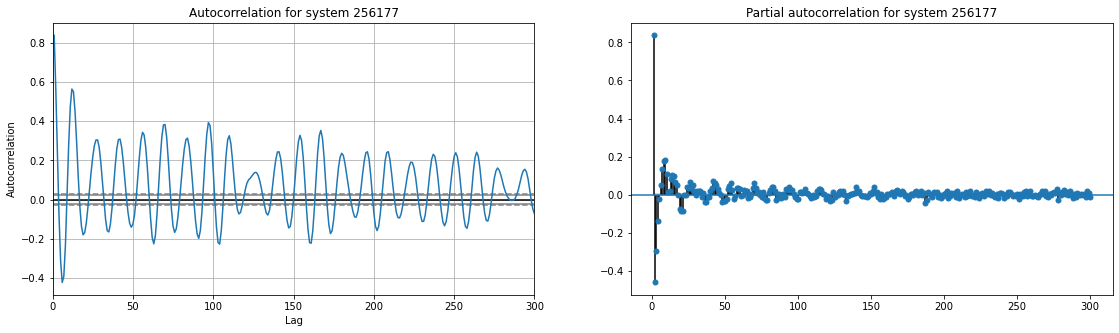

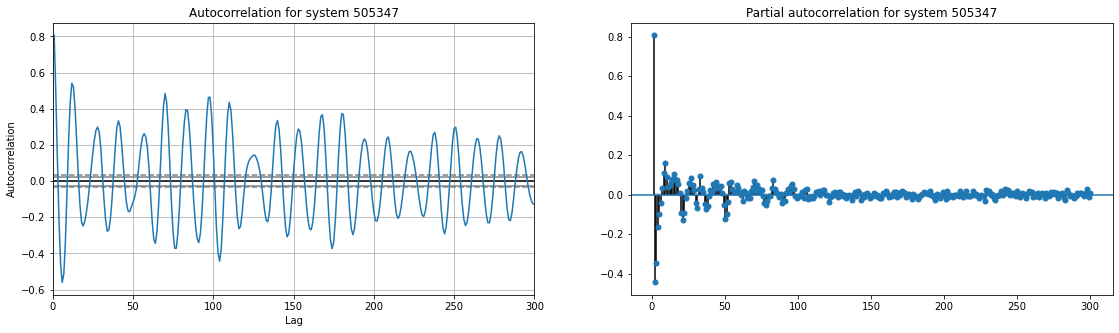

In [164]:
for site_id, df in dfs.items():
    plot_ac(df, 300, site_id)

103941


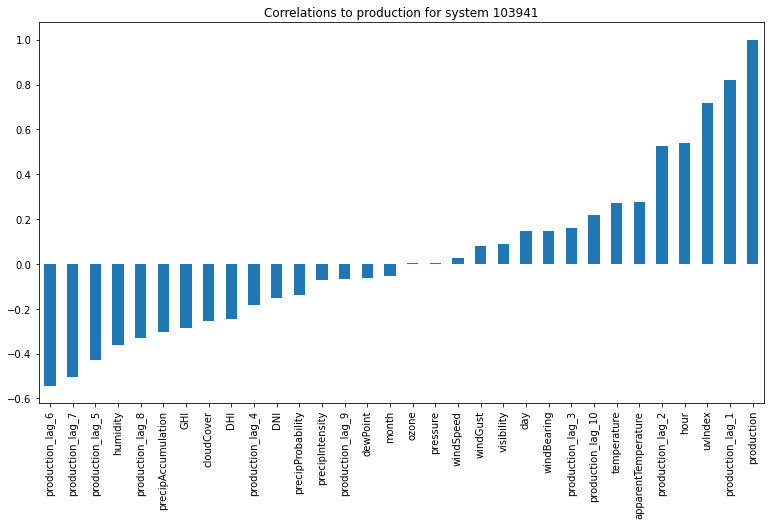

1232644


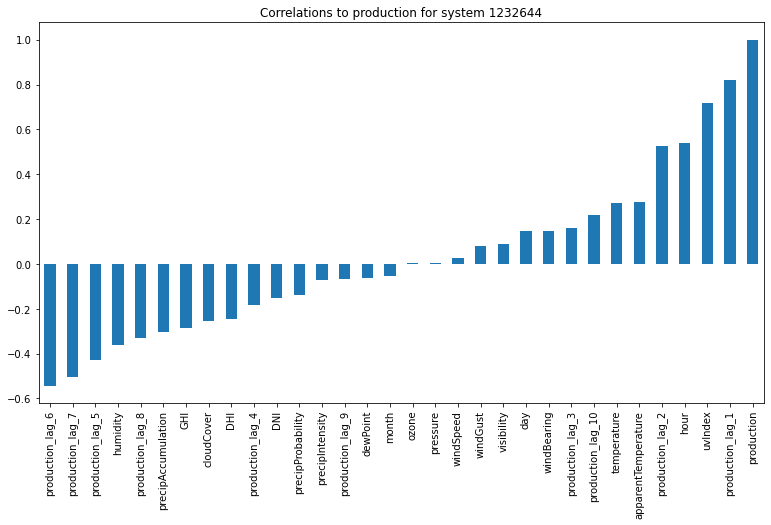

787197


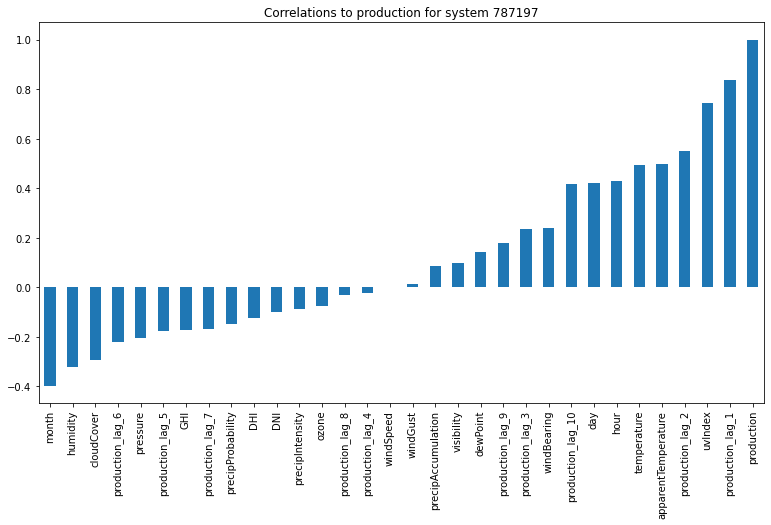

238320


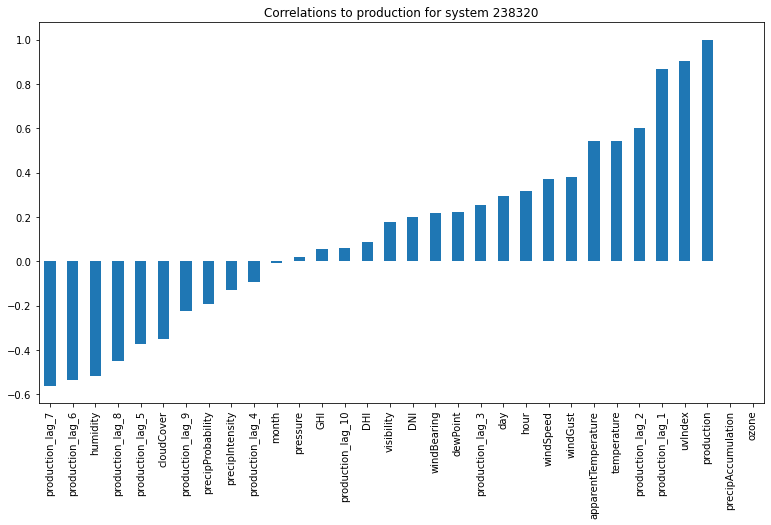

349060


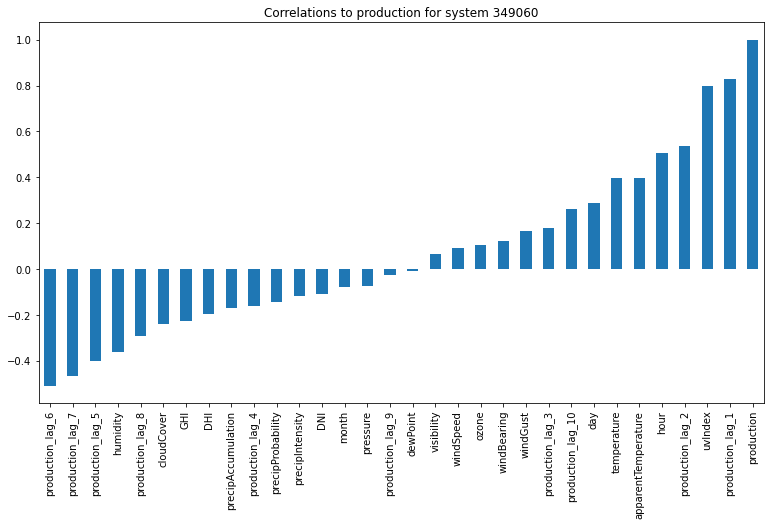

477834


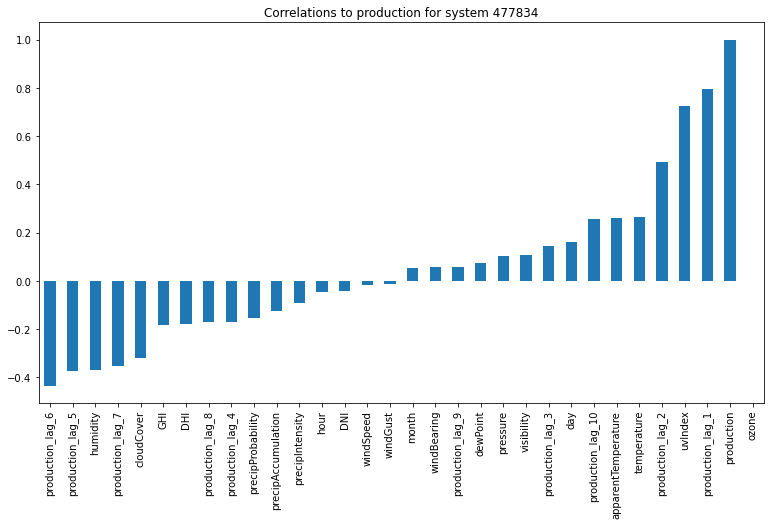

641826


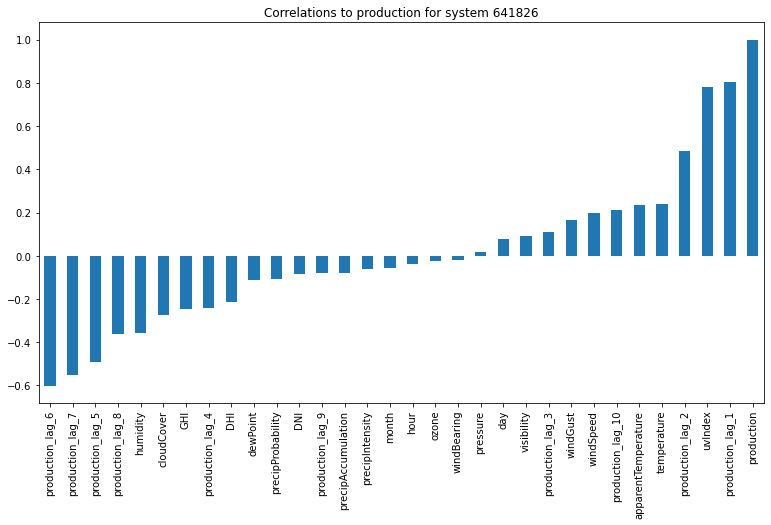

896164


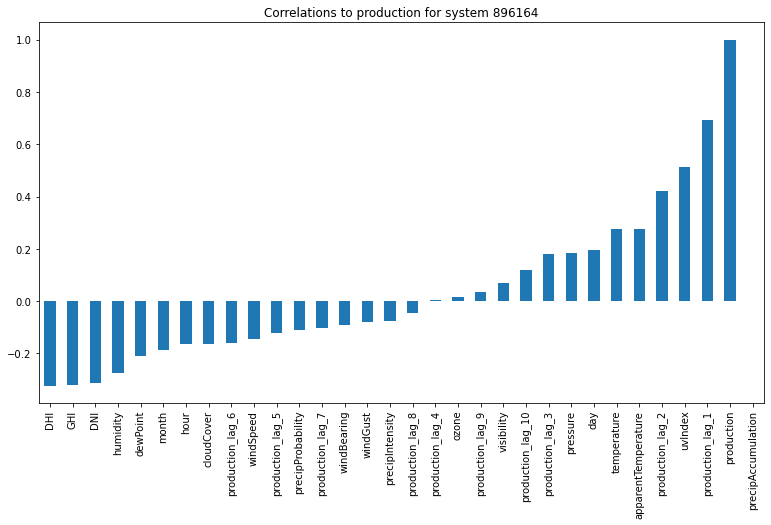

717193


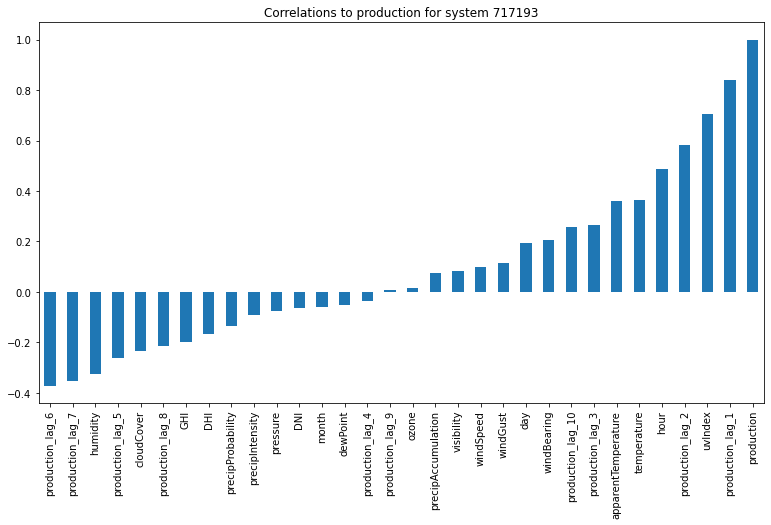

627759


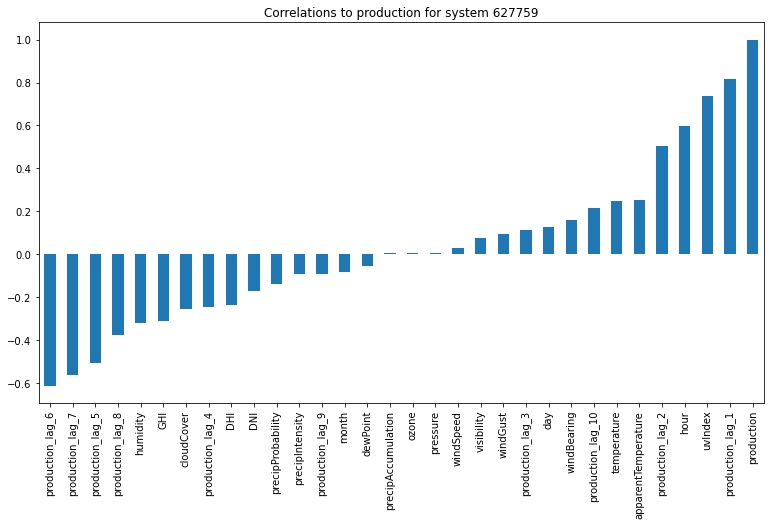

569932


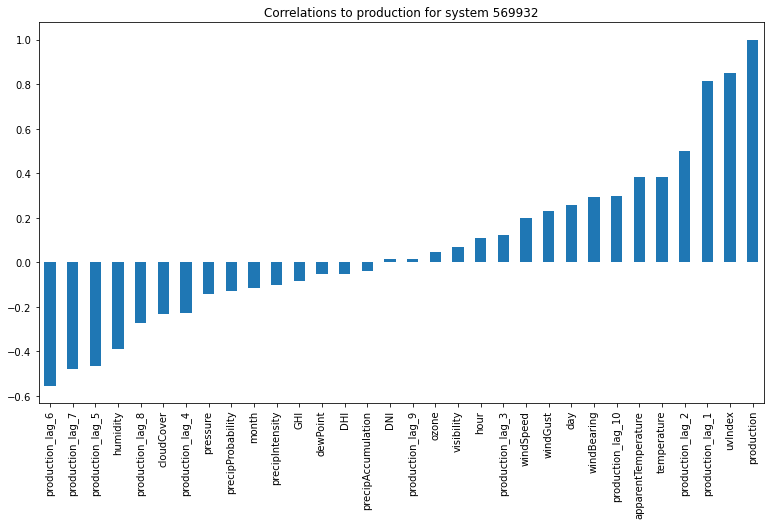

466851


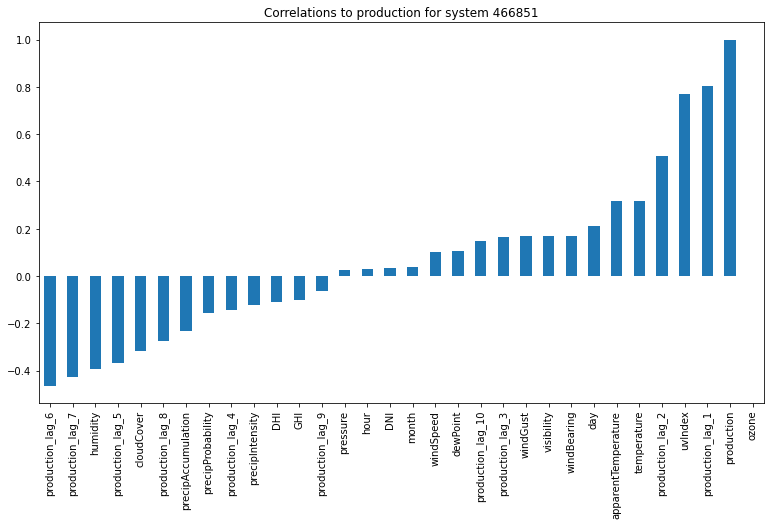

256177


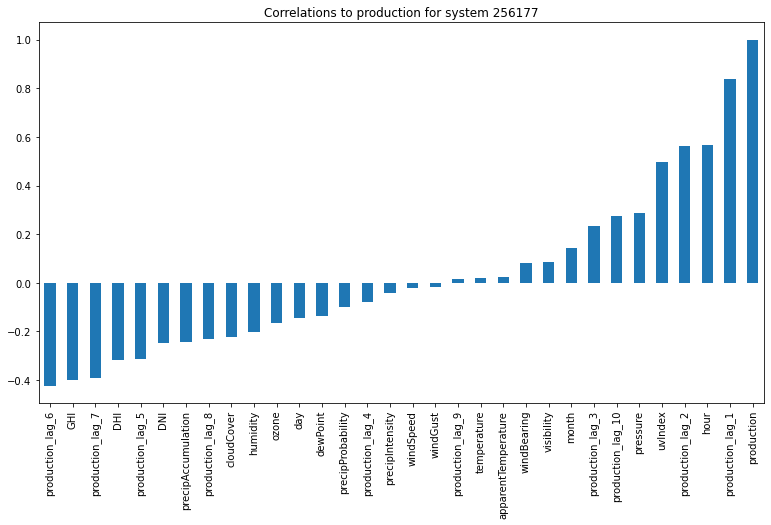

505347


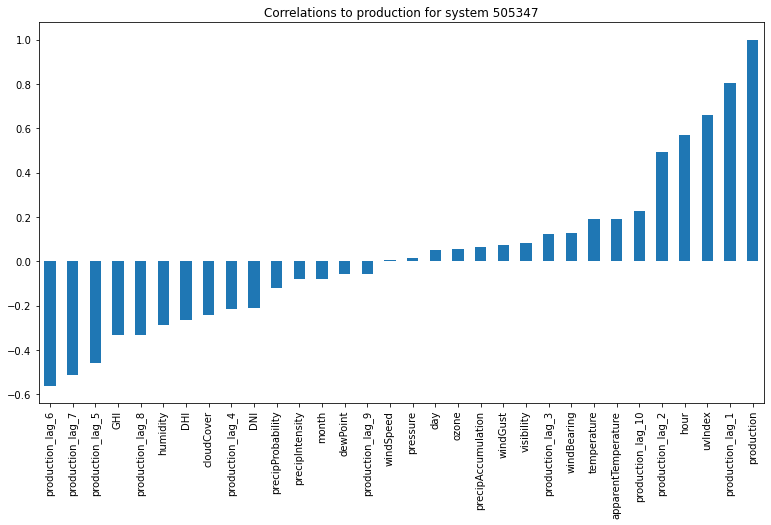

In [165]:
for site_id, df in dfs.items():
    print(site_id)
    plot_prod_corr(df, site_id, num_lags)

## Train Test Split
I'm going to use the sklearn [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to perform cross validation on the results of my model. 

In [365]:
from sklearn.model_selection import TimeSeriesSplit

def train_test_splits(df, num_splits):
    s = TimeSeriesSplit(num_splits)
    df = df.reset_index()
    splits = []
    for train_index, test_index in s.split(df):
        # print(train_index, test_index)        
        test, train = df.iloc[train_index], df.iloc[test_index]
        test = test.set_index('date')
        train = train.set_index('date')
        splits.append((test, train))
    return splits 

def plot_cv(splits):
    for split in splits:
        train, test = split
        figsize = (12, 5)
        train['production'].plot(figsize=figsize)
        test['production'].plot(figsize=figsize)
        plt.ylabel('production')
        plt.show()

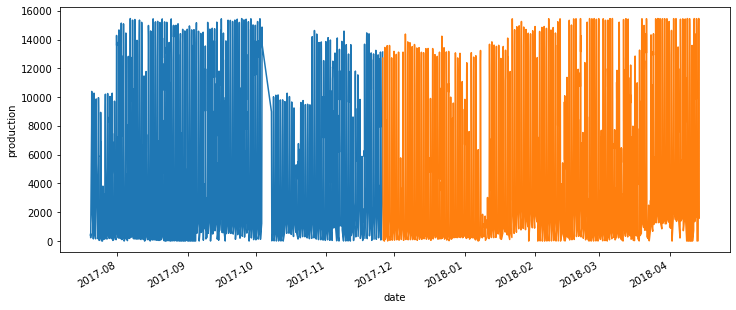

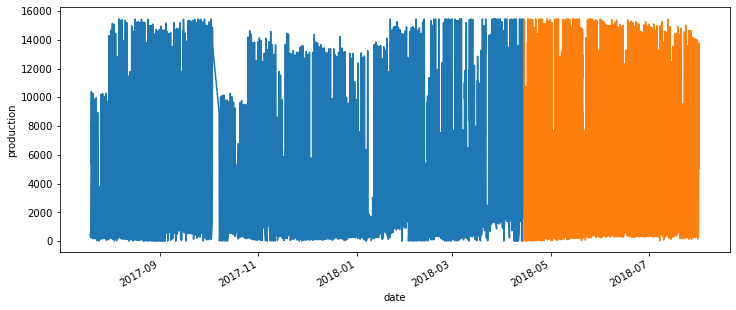

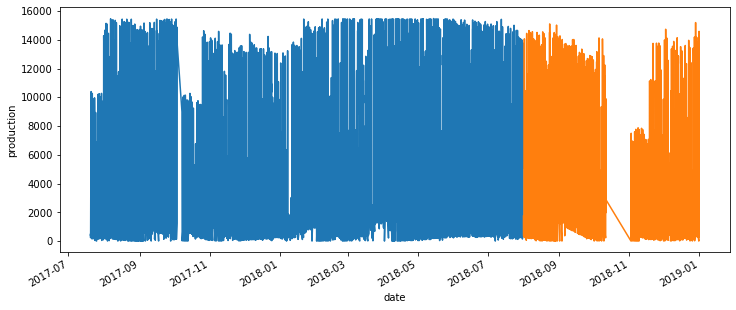

In [366]:
spits = train_test_splits(df, 3)
plot_cv(splits)

In [367]:
splits = train_test_splits(df, 3)
splits[0][0]

GHI    DHI    DNI  precipIntensity  \
date                                                              
2017-07-20 07:00:00+00:00  128.5  126.5    4.0              0.0   
2017-07-20 08:00:00+00:00   55.0   55.0    0.0              0.0   
2017-07-20 09:00:00+00:00   13.5   13.5    0.0              0.0   
2017-07-20 19:00:00+00:00    0.0    0.0    0.0              0.0   
2017-07-20 20:00:00+00:00   87.5   41.5  303.5              0.0   
...                          ...    ...    ...              ...   
2017-11-25 15:00:00+00:00    0.0    0.0    0.0              0.0   
2017-11-25 16:00:00+00:00    0.0    0.0    0.0              0.0   
2017-11-25 17:00:00+00:00    0.0    0.0    0.0              0.0   
2017-11-25 18:00:00+00:00    0.0    0.0    0.0              0.0   
2017-11-25 19:00:00+00:00    0.0    0.0    0.0              0.0   

                           precipProbability  precipAccumulation  temperature  \
date                                                                            
2017-07-20 07:00:00+00:00                0.0                 NaN        71.62   
2017-07-20 08:00:00+00:00                0.0                 NaN        69.80   
2017-07-20 09:00:00+00:00                0.0                 NaN        68.03   
2017-07-20 19:00:00+00:00                0.0                 NaN        80.67   
2017-07-20 20:00:00+00:00                0.0                 NaN        83.66   
...                                      ...                 ...          ...   
2017-11-25 15:00:00+00:00                0.0                 NaN        40.25   
2017-11-25 16:00:00+00:00                0.0                 NaN        49.94   
2017-11-25 17:00:00+00:00                0.0                 NaN        55.38   
2017-11-25 18:00:00+00:00                0.0                 NaN        62.59   
2017-11-25 19:00:00+00:00                0.0                 NaN        65.37   

                           apparentTemperature  dewPoint  humidity  ...  \
date                                                                ...   
2017-07-20 07:00:00+00:00                71.65     60.27      0.67  ...   
2017-07-20 08:00:00+00:00                69.81     59.90      0.71  ...   
2017-07-20 09:00:00+00:00                68.03     59.56      0.74  ...   
2017-07-20 19:00:00+00:00                81.16     58.95      0.48  ...   
2017-07-20 20:00:00+00:00                83.66     57.15      0.41  ...   
...                                        ...       ...       ...  ...   
2017-11-25 15:00:00+00:00                37.08     22.29      0.48  ...   
2017-11-25 16:00:00+00:00                49.94     22.72      0.34  ...   
2017-11-25 17:00:00+00:00                55.38     23.88      0.29  ...   
2017-11-25 18:00:00+00:00                62.59     29.96      0.29  ...   
2017-11-25 19:00:00+00:00                65.37     25.24      0.22  ...   

                           production_lag_4  production_lag_5  \
date                                                            
2017-07-20 07:00:00+00:00       7320.570539       7319.438387   
2017-07-20 08:00:00+00:00       7320.570539       7319.438387   
2017-07-20 09:00:00+00:00       7320.570539       7319.438387   
2017-07-20 19:00:00+00:00       7320.570539       7319.438387   
2017-07-20 20:00:00+00:00        409.529600       7319.438387   
...                                     ...               ...   
2017-11-25 15:00:00+00:00      11636.270500      13126.508000   
2017-11-25 16:00:00+00:00       9287.281000      11636.270500   
2017-11-25 17:00:00+00:00       3680.940200       9287.281000   
2017-11-25 18:00:00+00:00         72.668820       3680.940200   
2017-11-25 19:00:00+00:00       2633.560500         72.668820   

                           production_lag_6  production_lag_7  \
date                                                            
2017-07-20 07:00:00+00:00       7319.389373       7320.108383   
2017-07-20 08:00:00+00:00       7319.389373       7320.108383   
2017-07-20 09:00:00+0

## Linear Regression

To perform linear regression I'm first imputing missing values in the data using sklearns [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html). This uses machine learning techniques to impute all of the missing (nan) values in the data. The regression will run for each split and return the root mean squared error (RMSE) for each split 

In [368]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def drop_any_nan_cols(df):
    check_nan = df.isna().all()
    cols_to_drop = []
    if check_nan.any():
        columns = check_nan[check_nan == True]
        cols_to_drop = list(columns.index)
        # print(f'dropping columns: {cols_to_drop}')
        df = df.drop(columns=cols_to_drop)
    return df, cols_to_drop


def impute_values(df):
    df, cols_to_drop = drop_any_nan_cols(df)
    imp = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=0)
    imp.fit(df)
    df_np = imp.transform(df)
    df = pd.DataFrame(df_np, index=df.index, columns=df.columns)
    # display(df)
    return df, cols_to_drop


def run_regression(splits, site_id):
    print(f'System {site_id}')
    i = 1
    result = 0
    for split in splits:
        train, test = split
        x_cols = list(train.columns) 
        x_cols.remove('production')

        train_imp = train[x_cols]
        train_imp, tr_cols_to_drop = impute_values(train_imp)

        test_imp = test[x_cols]
        test_imp, te_cols_to_drop = impute_values(test_imp)

        cols_to_drop = set(tr_cols_to_drop).union(set(te_cols_to_drop))
        tr_cols_to_drop = set(list(train_imp.columns)).intersection(cols_to_drop)
        te_cols_to_drop = set(list(test_imp.columns)).intersection(cols_to_drop)
        train_imp = train_imp.drop(columns=tr_cols_to_drop)
        test_imp = test_imp.drop(columns=te_cols_to_drop)

        model = LinearRegression()
        model.fit(train_imp, train['production'])
        Y_pred = model.predict(test_imp)

        rmse = np.sqrt(mean_squared_error(test['production'], Y_pred)) 
        print(f'\tRMSE for split {i}: {rmse}')
        i += 1
        result = rmse 
    return result 
    # return rmse_norm

In [369]:
df = dfs[103941]
splits = train_test_splits(df, 3)
run_regression(splits, 103941)

System 103941
	RMSE for split 1: 170707.0456311591
	RMSE for split 2: 929.8481026873569
	RMSE for split 3: 274.1447676618812


274.1447676618812

I am running the regression starting out with 10 lags. 

In [386]:
num_lags = 10
dfs = {}
for site in site_md:
    try:
        df = get_final_df(site, num_lags)
    except FileNotFoundError:
        print(f'Skipping site {site["id"]}. No irradiance data ')
    dfs[site['id']] = df

Skipping site 1232644. No irradiance data 


In [387]:
first_results = {}

for site_id, df in dfs.items():
    splits = train_test_splits(df, 3)
    rmse = run_regression(splits, site_id)
    first_results[site_id] = rmse
first_results = pd.Series(first_results)
display(first_results)

System 103941
	RMSE for split 1: 170707.0456311591
	RMSE for split 2: 929.8481026873569
	RMSE for split 3: 274.1447676618812
System 1232644
	RMSE for split 1: 170707.0456311591
	RMSE for split 2: 929.8481026873569
	RMSE for split 3: 274.1447676618812
System 787197
	RMSE for split 1: 519.0235498739047
	RMSE for split 2: 701.2802314795521
	RMSE for split 3: 203634.92330263928
System 238320
	RMSE for split 1: 442.52787438388856
	RMSE for split 2: 170.40148234627358
	RMSE for split 3: 127.57340807870534
System 349060
	RMSE for split 1: 253.9843895504432
	RMSE for split 2: 7231841.831846327
	RMSE for split 3: 2222390.4332956644
System 477834
	RMSE for split 1: 486.1351023864471
	RMSE for split 2: 420.093177475187
	RMSE for split 3: 2541010.9023989625
System 641826
	RMSE for split 1: 908.2416354406813
	RMSE for split 2: 1285.6942346665855
	RMSE for split 3: 3457471072.2118917
System 896164
	RMSE for split 1: 273.6586102140081
	RMSE for split 2: 255.16617492397103
	RMSE for split 3: 188.78114

103941     2.741448e+02
1232644    2.741448e+02
787197     2.036349e+05
238320     1.275734e+02
349060     2.222390e+06
477834     2.541011e+06
641826     3.457471e+09
896164     1.887811e+02
717193     1.554509e+03
627759     8.509804e+02
569932     2.049940e+08
466851     2.647975e+07
256177     6.351579e+03
505347     2.199228e+03
dtype: float64

Running with 50 lags

In [383]:
num_lags = 50
dfs = {}
for site in site_md:
    try:
        df = get_final_df(site, num_lags)
    except FileNotFoundError:
        print(f'Skipping site {site["id"]}. No irradiance data ')
    dfs[site['id']] = df

Skipping site 1232644. No irradiance data 


In [384]:
second_results = {}

for site_id, df in dfs.items():
    splits = train_test_splits(df, 3)
    rmse = run_regression(splits, site_id)
    second_results[site_id] = rmse
second_results = pd.Series(second_results)
display(second_results)

System 103941
	RMSE for split 1: 1448363968.8694322
	RMSE for split 2: 771285025.1594877
	RMSE for split 3: 760224975.0233407
System 1232644
	RMSE for split 1: 1448363968.8694322
	RMSE for split 2: 771285025.1594877
	RMSE for split 3: 760224975.0233407
System 787197
	RMSE for split 1: 549.3668782429257
	RMSE for split 2: 723.4568975541631
	RMSE for split 3: 4649062.677872351
System 238320
	RMSE for split 1: 407.72566774709827
	RMSE for split 2: 174.90113529466686
	RMSE for split 3: 126.03225576027714
System 349060
	RMSE for split 1: 257.23749700690195
	RMSE for split 2: 58870564.96941205
	RMSE for split 3: 34464154.86924376
System 477834
	RMSE for split 1: 451.5817878736253
	RMSE for split 2: 504.96067920231866
	RMSE for split 3: 2803736.702054306
System 641826
	RMSE for split 1: 898.6782972001394
	RMSE for split 2: 1185.9181023503395
	RMSE for split 3: 48556582956.99224
System 896164
	RMSE for split 1: 460.75494868594234
	RMSE for split 2: 225.11092981630097
	RMSE for split 3: 182.933

103941     7.602250e+08
1232644    7.602250e+08
787197     4.649063e+06
238320     1.260323e+02
349060     3.446415e+07
477834     2.803737e+06
641826     4.855658e+10
896164     1.829333e+02
717193     1.965122e+03
627759     8.084602e+02
569932     2.744822e+09
466851     5.730409e+08
256177     3.292441e+08
505347     2.073085e+03
dtype: float64

In [388]:
results_df = pd.read_csv('Irradiance_results.csv')
results_df = results_df.set_index('site_id')
results_df['10_lags'] = first_results 
results_df['50_lags'] = second_results
results_df

irradiance_only     irr_time  weather_only  weather_time  \
site_id                                                             
103941        246.534541   225.476615    443.820703    333.608607   
787197        458.741006   441.875406    676.095814    493.189830   
238320        406.768778   400.295024    215.158797    194.184444   
349060        195.153020   195.418662    366.227301    277.764976   
477834        185.225738   182.273051    180.990243    165.603927   
641826       1415.125092  1356.645292   1400.275253   1340.890427   
896164        169.821445   173.107516    213.166462    209.297813   
717193       2452.825849  2423.531521   2755.743480   2454.798066   
627759        661.845473   562.320608   1158.978721    830.920466   
569932       1144.587302  1107.587695    912.295012    824.118052   
466851        391.530984   388.710669    387.033111    351.779515   
256177       1250.532543  1007.646441   1464.897083   1117.650983   
505347       2176.078319  1857.789721   3596.918498   2653.043743   

         weather_irr          all        t_loo  t_integrated       10_lags  \
site_id                                                                      
103941    230.734887   214.282454  1408.297236    962.852813  2.741448e+02   
787197    420.689423   414.346982  1139.275025   1051.837168  2.036349e+05   
238320    180.539331   179.062503  1216.435500   1046.116332  1.275734e+02   
349060    173.514858   172.418634  1063.147773    906.907098  2.222390e+06   
477834    146.007381   141.265141  1084.975457   1027.294537  2.541011e+06   
641826   1129.709809  1074.484228  1892.605357   1740.671072  3.457471e+09   
896164    165.401586   166.997995   977.995193    936.944873  1.887811e+02   
717193   2235.588756  2228.444875  3167.109357   3074.459545  1.554509e+03   
627759    604.447385   553.548312   987.753050    943.862437  8.509804e+02   
569932    742.778756   714.950626  1280.391308   1185.081394  2.049940e+08   
466851    325.688510   314.316423   803.562978    777.267431  2.647975e+07   
256177   1103.700017   967.449399  4347.582603   2328.248795  6.351579e+03   
505347   2004.302758  1799.138929  6092.258390   5290.500365  2.199228e+03   

              50_lags  
site_id                
103941   7.602250e+08  
787197   4.649063e+06  
238320   1.260323e+02  
349060   3.446415e+07  
477834   2.803737e+06  
641826   4.855658e+10  
896164   1.829333e+02  
717193   1.965122e+03  
627759   8.084602e+02  
569932   2.744822e+09  
466851   5.730409e+08  
256177   3.292441e+08  
505347   2.073085e+03

Text(0, 0.5, 'RMSE')

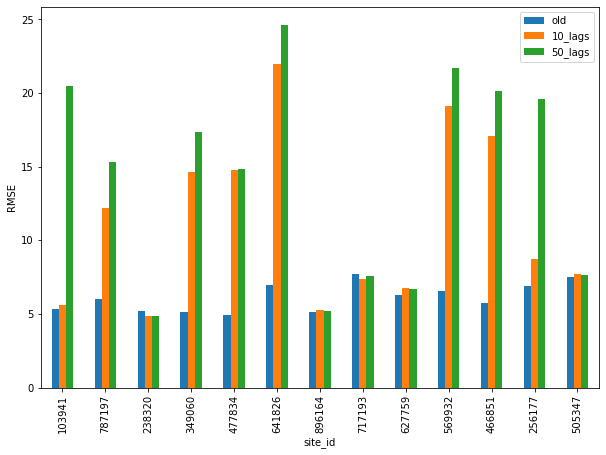

In [391]:
plot_df = results_df[['all', '10_lags', '50_lags']]
plot_df = plot_df.rename(columns={'all': 'old'})
plot_df_norm = plot_df.transform(np.log)
plot_df_norm.plot.bar(figsize=(10,7))
plt.ylabel('RMSE')

The results from the regression are surprising to me. Adding more lags completely degrades the performance of the model, and even when the number of lags was low, the performance still is not consistent. For some systems the RMSE gets lower as the the splits get larger, whereas for others the RMSE goes higher when the splits get larger. This doesn't make much sense to me. What I can derive from this is that either I am implementing the autoregressive part of the model incorrectly, or that a combination of an autoregressive model with a standard OLS does not work. An alternative explanation is that because I am already adding in the day, hour, and month as variables that they are explaining the seasonality and information of the time series, and that adding the lags introduces more complexity. 

# Home Usage Forecasting
I'm going to move onto home energy forecasting to see if the combination of weather data with a time series analysis will improve the performance of the model. I was hoping to gather more data but 